In [1]:
# kernal = py310_tf212


In [1]:
import tensorflow as tf 


In [2]:


print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
# from sgfmill import sgf
import glob


In [4]:
cfg = tf.compat.v1.ConfigProto() 
cfg.gpu_options.per_process_gpu_memory_fraction = 0.6 # 使用50%的GPU暫存  
session = tf.compat.v1.Session(config=cfg )

In [5]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Softmax,Dropout,BatchNormalization ,Concatenate,Reshape,GlobalMaxPooling2D ,Add,Activation  ,multiply,Lambda,GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras import backend as K


In [6]:

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	CA = channel_attention(cbam_feature, ratio)
	SA = spatial_attention(cbam_feature)
	
	combine = Concatenate()([CA,SA])
	
	return combine

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 9
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		


In [ ]:
def inception_block(x):
    x1 = Conv2D(16, (1, 1), activation='relu', padding='same')(x)
    x1 = BatchNormalization()(x1)
    
    x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    x3 = BatchNormalization()(x3)
    
    
    x9 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x9 = Conv2D(64, (9, 9), activation='relu', padding='same')(x9)
    x9 = BatchNormalization()(x9)
    

    concatted  = Concatenate()([x1,x3,x9]) #,x5,x7
    
    return concatted


In [7]:


# 定義模型
def build_model(num_input_planes=28, k=64, num_int_conv_layers=5): 
    input_layer = Input(shape=(19, 19, 10))
    
    x = inception_block(input_layer)
    x = Dropout(0.7)(x)
    cbam = cbam_block(x, 16)
    x = Dropout(0.5)(cbam)
    
    x = inception_block(x)
    x = Dropout(0.7)(x)
    cbam = cbam_block(x, 16)
    x = Dropout(0.5)(cbam)
    
    
    x = Conv2D(1, (1, 1), activation='linear', padding='same')(x)
    x = Flatten()(x)
    

    output_layer = Softmax()(x)
            
    return Model(inputs=input_layer, outputs=output_layer)

In [8]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 19, 19, 10)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 19, 19, 64)   5824        ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 19, 19, 32)   2912        ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 16)   176         ['input_1[0][0]']            

In [9]:

# 第一個評估指標：最高機率的準確度
top1_acc = tf.keras.metrics.CategoricalAccuracy(name='top1_acc')

# 第二個評估指標：最高機率的前五個準確度
def top5_acc(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

def top10_acc(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)


In [10]:
# 編譯模型

opt = tf.keras.optimizers.Adam(learning_rate = 0.001) #1e-4

model.compile(optimizer=opt,
              loss='categorical_crossentropy', #loss=tf.keras.losses.BinaryFocalCrossentropy(),          #loss='categorical_crossentropy',
              metrics=[top1_acc, top5_acc,top10_acc])


In [11]:
from keras.callbacks import ModelCheckpoint,CSVLogger

weight_file = '1127_newf10_batch100000_incep_atten'

val_top1_acc='weight/Kyu/' + weight_file + '/val_top1_acc_{val_top1_acc:.4f}.hdf5'
val_top5_acc='weight/Kyu/'+ weight_file +'/val_top5_acc_{val_top5_acc:.4f}.hdf5'
val_top10_acc='weight/Kyu/'+ weight_file +'/val_top10_acc_{val_top10_acc:.4f}.hdf5'
val_loss='weight/Kyu/'+ weight_file +'/val_loss_{val_loss:.4f}.hdf5'


checkpoint1 = ModelCheckpoint(val_top1_acc, monitor='val_top1_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max') #,period=1
checkpoint2 = ModelCheckpoint(val_top5_acc, monitor='val_top5_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
# checkpoint3 = ModelCheckpoint(val_top10_acc, monitor='val_top10_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
checkpoint4 = ModelCheckpoint(val_loss, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

csv_logger = CSVLogger('weight/Kyu/'+ weight_file +'/training_log.csv', append=True)


callbacks_list = [checkpoint1,checkpoint4,csv_logger] #,checkpoint3,checkpoint4

In [12]:
import matplotlib.pyplot as plt
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc1 = hist.history['top1_acc']
    tr_acc5 = hist.history['top5_acc']
    tr_loss = hist.history['loss']
    
    val_acc1 = hist.history['val_top1_acc']
    val_acc5 = hist.history['val_top5_acc']
    val_loss = hist.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    
    index_acc = np.argmax(val_acc1)
    acc_highest = val_acc1[index_acc]
    
    index_acc5 = np.argmax(val_acc5)
    acc5_highest = val_acc5[index_acc5]
    
    Epochs = [i+1 for i in range(len(tr_acc1))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'Top1 best epoch= {str(index_acc + 1)}'
    acc5_label = f'Top5 best epoch= {str(index_acc5 + 1)}'
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.ylim(-1,2.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc1, 'r', label= 'TOP1 Training Accuracy')
    plt.plot(Epochs, val_acc1, 'g', label= 'TOP1 Validation Accuracy')
    
    plt.plot(Epochs, tr_acc5, 'c', label= 'TOP5 Training Accuracy')
    plt.plot(Epochs, val_acc5, 'pink', label= 'TOP5 Validation Accuracy')
    
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.scatter(index_acc5 + 1 , acc5_highest, s= 150, c= 'red', label= acc5_label)
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout
    # plt.savefig('weight/Dan/'+weight_file + '/no' + str(NPZnum) +'NPZ.png')
    plt.show()
    

In [13]:
# import glob
loaded_data = np.load('E:/research/AIcup_GO/TrainingData/organize/Kyu/Design_feature_NPZ/1125_Kyu_newf10_fix/Kyu_train_dataset6_feature10_v2_times4_batch100000_0.npz')
x_train = loaded_data['x_train']
y_train = loaded_data['y_train']
x_train.shape ,y_train.shape

((118000, 4, 10, 19, 19), (118000, 4, 1, 19, 19))

In [14]:
x_train = x_train.reshape(-1, 10, 19, 19)
x_train.shape 

(472000, 10, 19, 19)

In [15]:
x_train = x_train.transpose(( 0, 2, 3 ,1))
x_train.shape

(472000, 19, 19, 10)

In [16]:
y_train = y_train.reshape(-1,361)
y_train.shape


(472000, 361)

In [17]:
loaded_data = np.load('E:/research/AIcup_GO/TrainingData/organize/Kyu/Design_feature_NPZ/1125_Kyu_newf10_fix/Kyu_train_dataset6_feature10_v2_times4_batch100000_118000.npz')
x_test = loaded_data['x_train']
y_test = loaded_data['y_train']
x_test.shape ,y_test.shape

((500, 4, 10, 19, 19), (500, 4, 1, 19, 19))

In [18]:
x_test = x_test.reshape(-1, 10, 19, 19)
x_test = x_test.transpose(( 0, 2, 3 ,1))
y_test = y_test.reshape(-1,361)
x_test.shape ,y_test.shape

((2000, 19, 19, 10), (2000, 361))

Epoch 1/100
7375/7375 [==============================] - ETA: 0s - loss: 3.0834 - top1_acc: 0.2901 - top5_acc: 0.6213 - top10_acc: 0.7293
Epoch 1: val_top1_acc improved from -inf to 0.41450, saving model to weight/Kyu/1127_newf10_batch100000_incep_atten\val_top1_acc_0.4145.hdf5

Epoch 1: val_loss improved from inf to 2.44165, saving model to weight/Kyu/1127_newf10_batch100000_incep_atten\val_loss_2.4416.hdf5
7375/7375 [==============================] - 447s 59ms/step - loss: 3.0834 - top1_acc: 0.2901 - top5_acc: 0.6213 - top10_acc: 0.7293 - val_loss: 2.4416 - val_top1_acc: 0.4145 - val_top5_acc: 0.7155 - val_top10_acc: 0.8125
Epoch 2/100
7375/7375 [==============================] - ETA: 0s - loss: 2.5480 - top1_acc: 0.3793 - top5_acc: 0.7107 - top10_acc: 0.8047
Epoch 2: val_top1_acc improved from 0.41450 to 0.43650, saving model to weight/Kyu/1127_newf10_batch100000_incep_atten\val_top1_acc_0.4365.hdf5

Epoch 2: val_loss improved from 2.44165 to 2.27775, saving model to weight/Kyu/1127

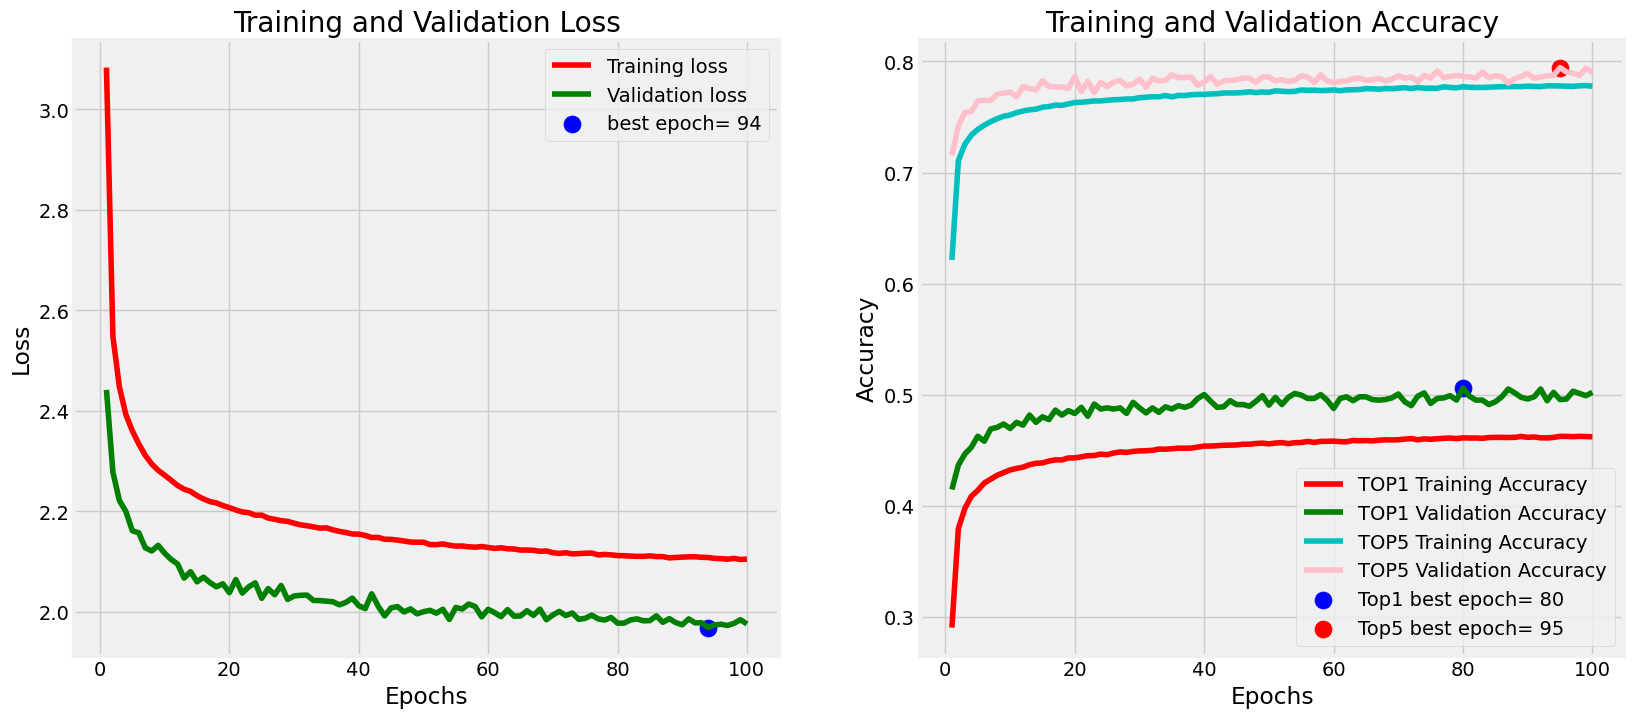

In [22]:
#data batch1
history = model.fit(x_train, y_train, epochs=100, batch_size=64,callbacks=callbacks_list, verbose=1,validation_data=(x_test,y_test)) #,validation_split=0.2
plot_training(history)
model.save('weight/Kyu/'+ weight_file +'/final_weight.hdf5')
    
# 506 mins    
    

In [24]:
model.save('weight/Dan/'+ weight_file +'/final_weight.hdf5')

In [ ]:

# 假設您已經訓練了一個模型並將其儲存為 `model`
# 假設 `x_test` 是您的測試數據

# 獲得預測結果
predictions = model.predict(x_test)

# 對於每一個預測結果，找出機率最高的 top1 和 top5 的索引
top1_indices = np.argmax(predictions, axis=-1)
top5_indices = np.argsort(predictions, axis=-1)[:, -5:]

# 輸出 top1 和 top5 的預測結果
print("Top1 Predicted Indices: ", top1_indices)
print("Top5 Predicted Indices: ", top5_indices)



In [ ]:
# 如果您想將這些索引轉換為棋盤上的座標（例如，(row, col) 格式）
top1_coordinates = [(idx // 19, idx % 19) for idx in top1_indices]
top5_coordinates = [[(idx // 19, idx % 19) for idx in top5] for top5 in top5_indices]

# 輸出轉換後的座標
print("Top1 Predicted Coordinates: ", top1_coordinates)
print("Top5 Predicted Coordinates: ", top5_coordinates)


## 下一步